In [58]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import scipy.sparse as sp

import warnings
warnings.filterwarnings("ignore")

# ref: https://www.kaggle.com/code/smlopezza/elliptic-data-set-eda-graphs-random-forest

#### Import dataset

In [59]:
# import data 
df_features = pd.read_csv('data/elliptic_txs_features.csv', header=None)
df_classes =  pd.read_csv("data/elliptic_txs_classes.csv")

df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

# merging dataframes
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge.drop(0, axis=1, inplace=True)

# check if there are duplicate txId
print("Number of duplicate txId: ", df_merge.duplicated(subset=['txId']).sum())

# rename column 0 to time_step
# df_merge.rename(columns={1: 'time_step'}, inplace=True)
display(df_merge.head())


Number of duplicate txId:  0


,1,2,3,4,5,6,7,8,9,10,...,159,160,161,162,163,164,165,166,txId,class
0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230425980,2
1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,2
2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,2
3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,0
4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,2


In [60]:
# rename column 0 to time_step
df_merge.rename(columns={1: 'time_step'}, inplace=True)
X = df_merge.drop(['class', 'txId'], axis=1)
y = df_merge['class']

# Setup trans ID to node ID mapping
nodes = df_merge['txId'].values
map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

X = df_merge.drop(['txId'], axis=1).copy()
print("unique=",X["class"].unique())

# Retain known vs unknown IDs
all_classified_idx = X['class'].loc[X['class']!=2].index # filter on known labels
all_unclassified_idx = X['class'].loc[X['class']==2].index
all_classified_illicit_idx = X['class'].loc[X['class']==1].index # filter on illicit labels
all_classified_licit_idx = X['class'].loc[X['class']==0].index # filter on licit labels

train_classified_idx = X.loc[(X['time_step'] <= 34) & (X['class'] != 2)].index
test_classified_idx = X.loc[(X['time_step'] > 34) & (X['class'] != 2)].index
# show ratio of illicit vs licit transactions in train and test set
train_classified_illicit_idx = X.loc[(X['time_step'] <= 34) & (X['class'] == 1)].index
train_classified_licit_idx = X.loc[(X['time_step'] <= 34) & (X['class'] == 0)].index

temp_X = X.copy()
# X.drop(columns=['time_step'], inplace=True)

# rename time_step to interger 1
X.rename(columns={'time_step': 1}, inplace=True)

Y = X['class']
X.drop(columns=['class'], inplace=True)
display(X.head())
display(Y.head())

unique= [2 0 1]


,1,2,3,4,5,6,7,8,9,10,...,157,158,159,160,161,162,163,164,165,166
0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


0    2
1    2
2    2
3    0
4    2
Name: class, dtype: int64

In [61]:
X_train = X.loc[train_classified_idx]
y_train = Y.loc[train_classified_idx]

X_test = X.loc[test_classified_idx]
y_test = Y.loc[test_classified_idx]

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest (also from scikit-learn, with 50 estimators and 50 max features)
# parameters from thr original paper
rf = RandomForestClassifier(n_estimators=100, max_features=50, random_state=42)

# Train the classifier
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=50, random_state=42)

In [63]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
rocauc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print("Accuracy: ", accuracy)
print("F1:       ", f1)
print("Precision:", precision)
print("Recall:   ", recall)
print("ROC AUC:  ", rocauc)

Accuracy:  0.9785242951409718
F1:        0.8145077720207253
Precision: 0.9279811097992916
Recall:    0.7257617728531855
ROC AUC:   0.9110998872619245


## test on each time step

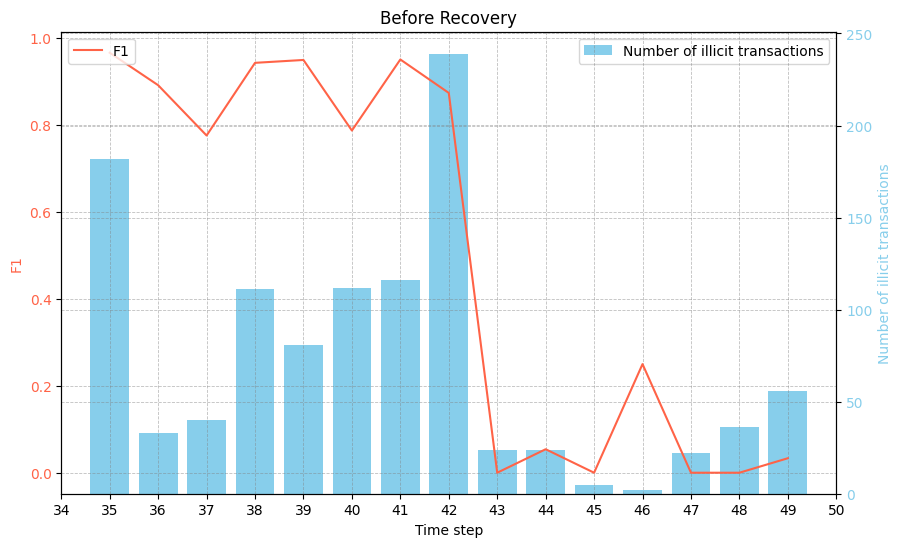

In [64]:
test_results = {}
for t in range(35, 50):

    # Make predictions on the test set
    y_pred = rf.predict(X_test.loc[X_test[1] == t])

    # Calculate accuracy
    accuracy = accuracy_score(y_test.loc[X_test[1] == t], y_pred)
    f1 = f1_score(y_test.loc[X_test[1] == t], y_pred, average='binary')
    precision = precision_score(y_test.loc[X_test[1] == t], y_pred)
    recall = recall_score(y_test.loc[X_test[1] == t], y_pred)
    rocauc = roc_auc_score(y_test.loc[X_test[1] == t], rf.predict_proba(X_test.loc[X_test[1] == t])[:, 1])
    num_illicit = temp_X.loc[(temp_X['time_step'] == t) & (temp_X['class'] == 1)].shape[0]

    test_results[t] = [num_illicit, f1, accuracy, precision, recall]
    
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Changing bar color to dark blue and line color to solid orange
ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(34, 50)
# Legend
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

# Changing y-label colors to match their corresponding plot elements
ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

# Changing tick colors to match their corresponding plot elements
ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Show every tick number
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Enhancing grid visibility
ax1.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)

# To put ax1 (F1 line) in the front
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
plt.title('Before Recovery')

plt.show()


## RF Black market shutdown testing

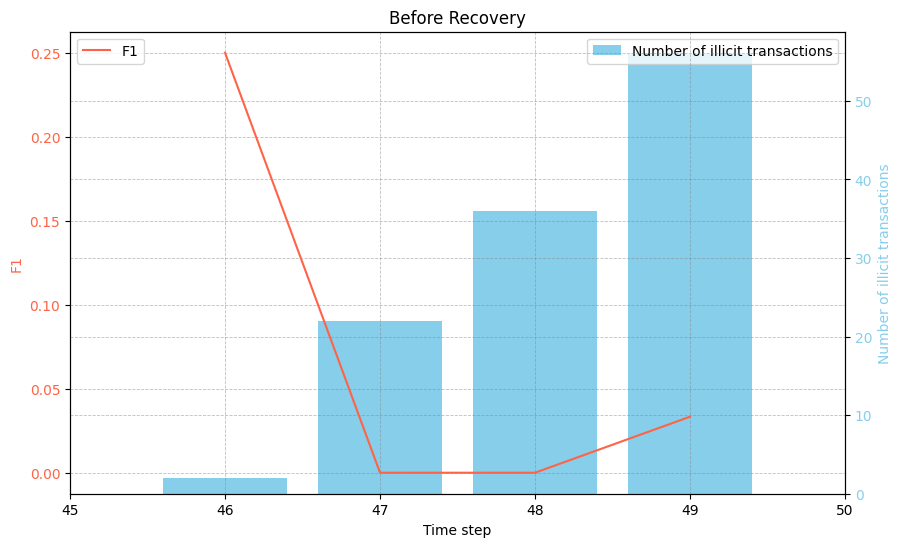

In [65]:
test_results = {}
for t in range(46, 50):

    # Make predictions on the test set
    y_pred = rf.predict(X_test.loc[X_test[1] == t])

    # Calculate accuracy
    accuracy = accuracy_score(y_test.loc[X_test[1] == t], y_pred)
    f1 = f1_score(y_test.loc[X_test[1] == t], y_pred, average='binary')
    precision = precision_score(y_test.loc[X_test[1] == t], y_pred)
    recall = recall_score(y_test.loc[X_test[1] == t], y_pred)
    rocauc = roc_auc_score(y_test.loc[X_test[1] == t], rf.predict_proba(X_test.loc[X_test[1] == t])[:, 1])
    num_illicit = temp_X.loc[(temp_X['time_step'] == t) & (temp_X['class'] == 1)].shape[0]

    test_results[t] = [num_illicit, f1, accuracy, precision, recall]
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Changing bar color to dark blue and line color to solid orange
ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(45, 50)
# Legend
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

# Changing y-label colors to match their corresponding plot elements
ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

# Changing tick colors to match their corresponding plot elements
ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Show every tick number
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Enhancing grid visibility
ax1.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)

# To put ax1 (F1 line) in the front
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
plt.title('Before Recovery')

plt.show()


## RF recovery testing

In [66]:
train_classified_idx = temp_X.loc[(((temp_X['time_step'] >= 43) & (temp_X['time_step'] <= 45)) | (temp_X['time_step'] <= 34)) & (temp_X['class'] != 2)].index
test_classified_idx = temp_X.loc[(temp_X['time_step'] > 45) & (temp_X['class'] != 2)].index

X_train = X.loc[train_classified_idx]
y_train = Y.loc[train_classified_idx]

X_test = X.loc[test_classified_idx]
y_test = Y.loc[test_classified_idx]

rf = RandomForestClassifier(n_estimators=100, max_features=50, random_state=42)
# Train the classifier
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=50, random_state=42)

Accuracy:  0.9838632273545291
F1:        0.8583464981569248
Precision: 0.9987745098039216
Recall:    0.752539242843952
ROC AUC:   0.9680210341726517


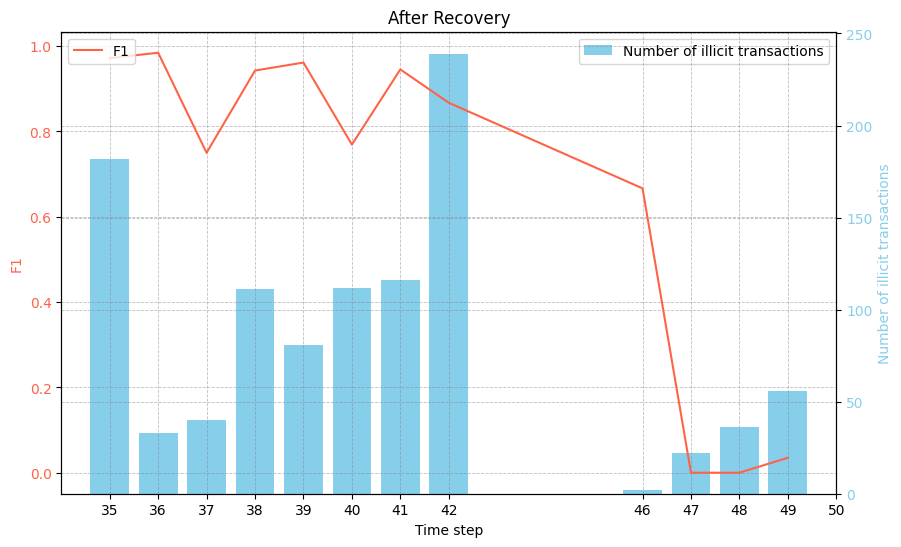

In [67]:
train_classified_idx = temp_X.loc[(temp_X['time_step'] <= 34) & (temp_X['class'] != 2)].index
test_classified_idx = temp_X.loc[(temp_X['time_step'] > 34) & (temp_X['class'] != 2)].index
X_train = X.loc[train_classified_idx]
y_train = Y.loc[train_classified_idx]
X_test = X.loc[test_classified_idx]
y_test = Y.loc[test_classified_idx]

y_pred = rf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
rocauc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print("Accuracy: ", accuracy)
print("F1:       ", f1)
print("Precision:", precision)
print("Recall:   ", recall)
print("ROC AUC:  ", rocauc) 

test_results = {}
for t in range(35, 50):

    # Make predictions on the test set
    y_pred = rf.predict(X_test.loc[X_test[1] == t])

    # Calculate accuracy
    accuracy = accuracy_score(y_test.loc[X_test[1] == t], y_pred)
    f1 = f1_score(y_test.loc[X_test[1] == t], y_pred, average='binary')
    precision = precision_score(y_test.loc[X_test[1] == t], y_pred)
    recall = recall_score(y_test.loc[X_test[1] == t], y_pred)
    rocauc = roc_auc_score(y_test.loc[X_test[1] == t], rf.predict_proba(X_test.loc[X_test[1] == t])[:, 1])
    num_illicit = temp_X.loc[(temp_X['time_step'] == t) & (temp_X['class'] == 1)].shape[0]

    test_results[t] = [num_illicit, f1, accuracy, precision, recall]
    

test_list = [35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50]
# remove the key-value pairs with key not in test_list
test_results = {key:val for key, val in test_results.items() if key in test_list}

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Changing bar color to dark blue and line color to solid orange
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)

ax1.set_xlim(34, 50)
# Legend
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

# Changing y-label colors to match their corresponding plot elements
ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

# Changing tick colors to match their corresponding plot elements
ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Show every tick number
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# remove 43, 44, 45
ax1.set_xticks([35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50])
ax2.set_xticks([35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50])

# Enhancing grid visibility
ax1.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)

# To put ax1 (F1 line) in the front
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
plt.title('After Recovery')

plt.show()


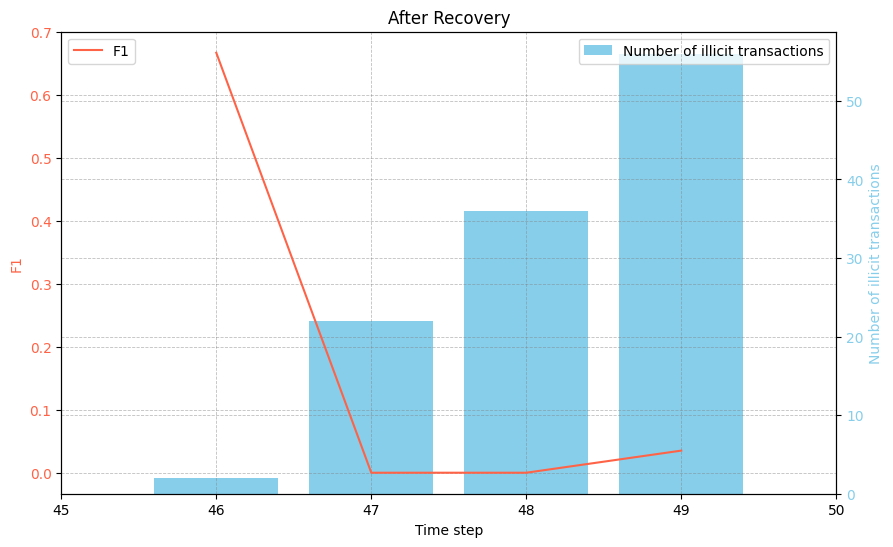

In [68]:
train_classified_idx = temp_X.loc[(((temp_X['time_step'] >= 43) & (temp_X['time_step'] <= 45)) | (temp_X['time_step'] <= 34)) & (temp_X['class'] != 2)].index
test_classified_idx = temp_X.loc[(temp_X['time_step'] > 45) & (temp_X['class'] != 2)].index
X_train = X.loc[train_classified_idx]
y_train = Y.loc[train_classified_idx]
X_test = X.loc[test_classified_idx]
y_test = Y.loc[test_classified_idx]

test_results = {}
for t in range(46, 50):

    # Make predictions on the test set
    y_pred = rf.predict(X_test.loc[X_test[1] == t])

    # Calculate accuracy
    accuracy = accuracy_score(y_test.loc[X_test[1] == t], y_pred)
    f1 = f1_score(y_test.loc[X_test[1] == t], y_pred, average='binary')
    precision = precision_score(y_test.loc[X_test[1] == t], y_pred)
    recall = recall_score(y_test.loc[X_test[1] == t], y_pred)
    rocauc = roc_auc_score(y_test.loc[X_test[1] == t], rf.predict_proba(X_test.loc[X_test[1] == t])[:, 1])
    num_illicit = temp_X.loc[(temp_X['time_step'] == t) & (temp_X['class'] == 1)].shape[0]

    test_results[t] = [num_illicit, f1, accuracy, precision, recall]
    
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Changing bar color to dark blue and line color to solid orange
ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(45, 50)
# Legend
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

# Changing y-label colors to match their corresponding plot elements
ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

# Changing tick colors to match their corresponding plot elements
ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Show every tick number
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Enhancing grid visibility
ax1.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)

# To put ax1 (F1 line) in the front
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
plt.title('After Recovery')

plt.show()
